In [2]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import argparse
import datetime
import importlib
import os
import tensorflow as tf
import yaml
import math
#from dataset.helper import DatasetHelper
from dataset.scenenet_dataset import ScenenetDataset
from train_utils import *
import sys
sys.path.append('/nethome/shickson3/CreateNormals/')
from python.calc_normals import NormalCalculation
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [24]:
file_address = open('config/scenenet/test/normals_labels.config')
config = yaml.load(file_address)
normals_matrix = np.zeros([4])

/nethome/shickson3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [8]:
def compute_normals_matrix(normals_gt, pred, depths, normals_matrix):
    weights = ~((np.squeeze(depths) == 0) + (normals_gt[..., :] == [0,0,0])[..., 0])
    num_weights = float(np.sum(weights))
    gt_norm = normals_gt / (np.linalg.norm(normals_gt,axis=-1, keepdims=True)+1e-10)
    pred_norm = pred / (np.linalg.norm(pred,axis=-1, keepdims=True)+1e-10)
    cos_dist = (gt_norm[..., 0] * pred_norm[..., 0] + gt_norm[..., 1] * pred_norm[..., 1] + gt_norm[..., 2] * pred_norm[..., 2])
    dist_angle = 180.0 / math.pi * np.arccos(np.clip(cos_dist, -1.0, 1.0))
    masked_dist = dist_angle[weights]
    below_11_25 = np.sum(masked_dist <= 11.25) / num_weights
    below_22_5 = np.sum(masked_dist <= 22.5) / num_weights
    below_30 = np.sum(masked_dist <= 30.0) / num_weights
    mean = np.mean(masked_dist)
    normals_matrix += np.array([below_11_25, below_22_5, below_30, mean])
    return normals_matrix

def compute_label_matrix(label_max, pred_max, output_matrix):
    # Input:
    # label_max shape(B,H,W): np.argmax(one_hot_encoded_label,3)
    # pred_max shape(B,H,W): np.argmax(softmax,3)
    # output_matrix shape(NUM_CLASSES,3): if func is called first time an array of 
    #                                     zeros.
    # Output:
    # output_matrix shape(NUM_CLASSES,3): columns with total count of true positives,
    #                                     false positives and false negatives.
    for i in xrange(output_matrix.shape[0]):
        temp = pred_max == i
        temp_l = label_max == i
        tp = np.logical_and(temp, temp_l)
        temp[temp_l] = True
        fp = np.logical_xor(temp, temp_l)
        temp = pred_max == i
        temp[fp] = False
        fn = np.logical_xor(temp, temp_l)
        output_matrix[i, 0] += np.sum(tp)
        output_matrix[i, 1] += np.sum(fp)
        output_matrix[i, 2] += np.sum(fn)

    return output_matrix

def compute_iou(output_matrix):
    # Input:
    # output_matrix shape(NUM_CLASSES,3): columns with total count of true positives,
    #                                     false positives and false negatives.
    # Output:
    # IoU in percent form (doesn't count label id 0 contribution as it is assumed to be void) 
    return np.sum(output_matrix[1:, 0]/(np.sum(output_matrix[1:, :], 1).astype(np.float32)+1e-10))/(output_matrix.shape[0]-1)*100

def get_label_metrics(probabilities, feed_dict, labels_pl, labels_matrix):
    prediction = np.argmax(probabilities, axis=-1)
    label = feed_dict[labels_pl]
    gt = np.argmax(label, axis=-1)
    prediction[gt == 0] = 0
    return compute_label_matrix(gt, prediction, labels_matrix)


In [5]:
module = importlib.import_module('models.' + config['model'])
model_func = getattr(module, config['model'])
dataset_name = config['dataset_name']
if dataset_name == 'nyu13':
    helper = NYU13Dataset()
elif dataset_name == 'nyu40':
    helper = NYU40Dataset()
elif dataset_name == 'scenenet':
    helper = ScenenetDataset()
elif dataset_name == 'scannet':
    helper = ScannetDataset()
else:
    print('Non-existant Dataset')
helper.Setup(config)
modalities_num_classes, num_label_classes = extract_modalities(config)
data_list, iterator = helper.get_test_data(config, num_label_classes)
resnet_name = 'resnet_v2_50'

with tf.variable_scope(resnet_name):
    model = model_func(modalities_num_classes=modalities_num_classes, training=False)
    images_pl, depths_pl, normals_pl, labels_pl, update_ops = setup_model(model, config, train=False)

config1 = tf.ConfigProto()
config1.gpu_options.allow_growth = True
sess = tf.Session(config=config1)
sess.run(tf.global_variables_initializer())
import_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
print 'total_variables_loaded:', len(import_variables)
saver = tf.train.Saver(import_variables)
saver.restore(sess, config['checkpoint'])
#sess.run(iterator.initializer)
step = 0
total_num = 0
labels_matrix = np.zeros([num_label_classes, 3])
normals_matrix = np.zeros([4])
start_step = 0

W0909 16:56:58.565027 139645371307776 deprecation.py:323] From dataset/helper.py:105: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
W0909 16:56:59.851450 139645371307776 deprecation.py:323] From dataset/helper.py:123: make_one_shot_iterator (from tensorflow.python.data.

Network_Construction


W0909 16:58:04.321321 139645371307776 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0909 16:58:04.795342 139645371307776 deprecation_wrapper.py:119] From models/network_base.py:113: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0909 16:58:06.481193 139645371307776 deprecation.py:506] From models/network_base.py:252: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0909 16:58:07.091049 139645371307776 deprecation_wrapper.py:119] From mod

total_variables_loaded: 438


W0909 16:58:14.718776 139645371307776 deprecation.py:323] From /nethome/shickson3/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [48]:
feed_dict = setup_feeddict(data_list, sess, images_pl, depths_pl, normals_pl, labels_pl, config)

In [49]:
inputs = dict()
for mod in config['output_modality']:
    if mod == 'labels':
        inputs[mod] = model.softmax
    elif mod == 'normals':
        inputs[mod] = model.output_normals
results = sess.run(list(inputs.values()), feed_dict=feed_dict)
for mod, result in zip(list(inputs.keys()), results):
    if mod == 'labels':
        labels_matrix = get_label_metrics(result, feed_dict, labels_pl, labels_matrix)
    elif mod == 'normals':
        normals_matrix = compute_normals_matrix(feed_dict[normals_pl], result, feed_dict[depths_pl], normals_matrix)

total_num += config['batch_size']
print normals_matrix
print compute_iou(labels_matrix)

[ 2.71227385  2.87661195  2.91299487 18.53238821]
30.53539016288942


['labels', 'normals']


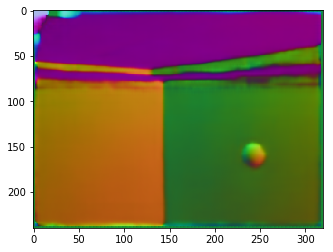

In [36]:
t = 0
print inputs.keys()
output_normals = results[1]
#print output_normals.shape
test_normal = output_normals[t,:,:,:]
test_normal = test_normal / (np.linalg.norm(test_normal,axis=-1, keepdims=True)+1e-10)
plt.imshow((test_normal + 1.0) / 2.0)

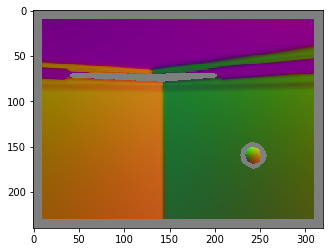

In [37]:
input_normals = feed_dict[normals_pl]
gt_normal = input_normals[t,:,:,:]
gt_normal = gt_normal / (np.linalg.norm(gt_normal,axis=-1, keepdims=True)+1e-10)
plt.imshow((gt_normal + 1.0) / 2.0)

(240, 320)


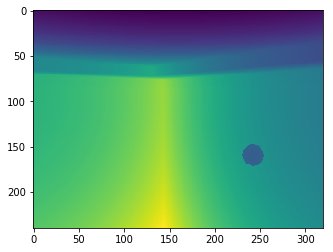

In [38]:
depths = feed_dict[depths_pl]
gt_depth = depths[t,:,:,:].reshape((240,320))
print gt_depth.shape
plt.imshow(gt_depth)

(240, 320)
64438.0
bool
bool


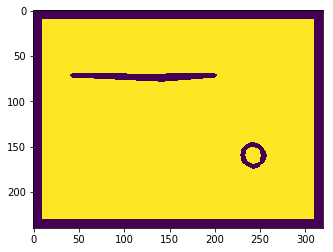

In [39]:
weights = ~((np.squeeze(depths) == 0) + (input_normals[..., :] == [0,0,0])[..., 0])
input_weight = weights[t,...]
print input_weight.shape
plt.imshow(input_weight)
print(float(np.sum(input_weight)))
print input_weight.dtype
print weights.dtype

In [40]:
normals_matrix = [0,0,0,0]
print(compute_normals_matrix(gt_normal, test_normal, gt_depth, normals_matrix))

[0.92218877 0.96924175 0.97863062 4.77975082]


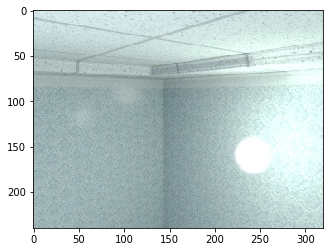

In [41]:
rgb = feed_dict[images_pl]
test_rgb = ((rgb[t,...]+ 63.75) * 2).astype(np.uint8)
plt.imshow(test_rgb)

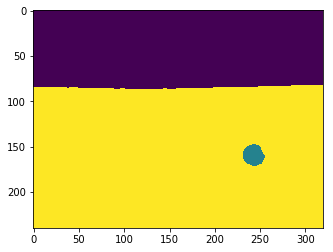

In [42]:
output_labels = results[0]
test_label = np.argmax(output_labels[t,:,:,:], axis=-1)
plt.imshow(test_label)

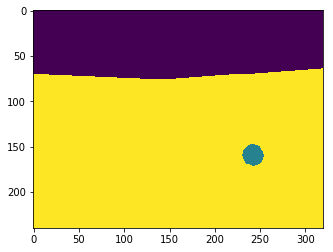

In [43]:
labels = feed_dict[labels_pl]
gt_label = np.argmax(labels[t,:,:,:], axis=-1)
plt.imshow(gt_label)